# Comparison of MS partitions and NUTS over time

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import mercantile
from shapely.geometry import shape
import networkx as nx
import pickle
import scipy.sparse as sp
from scipy.optimize import least_squares
import datetime
from sklearn import metrics
import seaborn as sns
from tqdm import tqdm

In [43]:
import sys
from pathlib import Path
path = str(Path.cwd().parents[0])

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

from network_analysis import compute_indicator_matrix, flow_coverage, flow_coverage_community, compute_containment
from utils import R2_score
from response_model import select_model, return_response_parameters

root_figure = path+"/figures/"
root_map = path+'/data/geo_shapefiles/Local_Authority_Districts__May_2020__Boundaries_UK_BGC-shp/Local_Authority_Districts__May_2020__Boundaries_UK_BGC.shp'
root_baseline_data = path+'/data/fb_movement_maps/BETWEEN_TILES_BASELINE.csv'
root_processed = path+"/data/processed/"
root_networks = path+"/data/processed/networks/"
root_results = path+"/results/"

In [3]:
plt.rcParams.update({'font.size': 20})

## Import different networks and data

In [4]:
#################
# Load datasets #
#################

# Load LSCC
root_lscc = root_networks+'/base_network_lscc.npz'
with open(root_lscc, 'rb') as handle:
        lscc_dict = pickle.load(handle)

# Reads in the timeseries of between tiles movement data
root1 = path+'/data/fb_movement_maps/BETWEEN_TILES_TRIP_NUMBERS.csv'
df = pd.read_csv(root1)
        
##############################
# Generate DiGraph from data #
##############################

lscc = nx.from_dict_of_dicts(lscc_dict,create_using = nx.DiGraph)
lscc_nodes = list(lscc.nodes())
n_nodes = len(lscc_nodes)

# Store node numbers
node_numbers = {i : lscc_nodes[i] for i in range(n_nodes)}

# Load geom_dict
root_geom_dict = root_networks+'/base_geom_dict.pickle'
with open(root_geom_dict, 'rb') as handle:
        geom_dict = pickle.load(handle)
# Gemo dict for node keys
geom_dict_numbers = {i : geom_dict[node_numbers[i]] for i in range(n_nodes)}

# Compute adjacency matrix and node list of LSCC
A_LSCC = nx.adjacency_matrix(lscc)
A_LSCC_array = A_LSCC.toarray()
lscc_nodes_list = np.asarray(list(lscc.nodes()))
s_lscc = len(lscc_nodes_list)

###########################
# Get dates of timeseries #
###########################

# Get start and end dates
start_date = df.columns.values[2][:10]
end_date = df.columns.values[-1][:10]

# Generate DatetimeIndex
days = pd.date_range(start=start_date, end=end_date).date
n_days = len(days)
days_dm = np.asarray([str(days[i])[5:] for i in range(n_days)])
days_week = np.asarray(pd.date_range(start=start_date, end=end_date).weekofyear, dtype='int')
weeks = np.arange(days_week.min(),days_week.max())

# Indicate weekdays
weekday = pd.date_range(start=start_date, end=end_date).weekday<5

# Consider bank holidays
bank_holidays = []
bank_holidays.append(np.argwhere(days==datetime.date(2020, 4, 10))[0][0])
bank_holidays.append(np.argwhere(days==datetime.date(2020, 4, 13))[0][0])
bank_holidays.append(np.argwhere(days==datetime.date(2020, 5, 8))[0][0])
bank_holidays.append(np.argwhere(days==datetime.date(2020, 5, 25))[0][0])
weekday[bank_holidays] = False


# Store lockdown-date
lockdown_date = pd.to_datetime('20200324', format='%Y%m%d', errors='ignore')
lockdown_date_number = np.argwhere(days == lockdown_date).flatten()[0]
lockdown_week = lockdown_date.week

# Store date information
timestamps = {'days' : days, 'weekdays' : weekday, 'weeks' : weeks, 
              'lockdown_day' : lockdown_date}

# root_store = '/home/tc/OneDrive/Software/Mobility Data Code/Results/'+country+'/Timeseries/'
# root3 = root_store+'timestamps.pkl'

# # Store data (serialize)
# with open(root3, 'wb') as handle:
#     pickle.dump(timestamps, handle, protocol=pickle.HIGHEST_PROTOCOL)

/tmp/ipykernel_5769/1188815187.py:50: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  days_week = np.asarray(pd.date_range(start=start_date, end=end_date).weekofyear, dtype='int')
/tmp/ipykernel_5769/1188815187.py:67: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  lockdown_date_number = np.argwhere(days == lockdown_date).flatten()[0]


## Construct daily digraphs

Generate network for each day by summing over all hours per day. 

In [6]:
def rewire_graph(G):
    '''
    Permute nodes in datastructure such that G.nodes() == lscc.nodes()
    '''
    n_nodes = len(G.nodes())
    G_dict = nx.to_dict_of_dicts(G)
    new_dict = {list(lscc_dict.keys())[i] : G_dict[list(lscc_dict.keys())[i]] for i in range(n_nodes)}
    G_new = nx.from_dict_of_dicts(new_dict, create_using = nx.DiGraph)
    
    return G_new

In [7]:
compute_again = False

if compute_again == True:
    
    # Converting the quadkeys to strings
    df['start_quadkey'] = df['start_quadkey'].astype(str)
    df['end_quadkey'] = df['end_quadkey'].astype(str)
    # adding a leading '0' to quadkeys beginning with 3 so it maps on to web mercator
    df.loc[df['start_quadkey'].str[:1] == '3', 'start_quadkey'] = '0'+df['start_quadkey']
    df.loc[df['end_quadkey'].str[:1] == '3', 'end_quadkey'] = '0'+df['end_quadkey']

    # Replace nan by 0
    df = df.fillna(0)
    
    ###################################
    # Filtering out rows outside LSCC #
    ###################################

    # Get LSCC quadkeys
    quadkeys_timeseries_LSCC = set(lscc_dict.keys())

    df_filtered = df.copy()

    for i in range(df.shape[0]):

        start_included =  df.iloc[i]['start_quadkey'] in quadkeys_timeseries_LSCC
        end_included = df.iloc[i]['end_quadkey'] in quadkeys_timeseries_LSCC 
        included = start_included + end_included

        if included != 2:
            df_filtered = df_filtered.drop([i])

    print('Number of deleted rows:', df.shape[0] - df_filtered.shape[0])

    df = df_filtered.reset_index(drop=True)
    
    #####################################
    # Generate daily DiGraphs from data #
    #####################################

    # Get the first two quadkey columns
    df_key = df.iloc[:,:2]

    M = df.shape[1]-3
    networks = []

    for i in range(1,M,3):

        # Get daily data 
        df_mov = df.iloc[:,i+1:i+4]
        df_sum = pd.Series(df_mov.sum(axis=1),name='movement')
        df_sum = pd.concat([df_key,df_sum],axis=1)

        # Generate DiGraph 
        N = len(df_sum)
        G = nx.DiGraph()
        # for each row, add nodes and weighted edge
        for j in range(0,N):
            start = df_sum['start_quadkey'][j]
            end = df_sum['end_quadkey'][j]
            weight = df_sum['movement'][j]
            G.add_node(start)
            G.add_node(end)
            if weight > 0.0:
                G.add_weighted_edges_from([(start, end, weight)] )

        # Append DiGraph to list of networks
        networks.append(G)

    ###########################################
    # Permute nodes such that they match LSCC #
    ###########################################

    for i in range(len(networks)):
        networks[i] = rewire_graph(networks[i])
        
    ########################
    # Store daily DiGraphs #
    ########################

    root4 = root_store+'timeseries_daily_digraphs_lscc.pkl'

    # Store data (serialize)
    with open(root4, 'wb') as handle:
        pickle.dump(networks, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
# Load networks      
else: 
    
    root4 = root_networks+'timeseries_daily_digraphs_lscc.pkl'
    with open(root4, 'rb') as handle:
        networks = pickle.load(handle)    

In [8]:
##############################
# Compute adjacency matrices #
##############################

n_networks = len(networks)
networks_adjacency = [nx.adjacency_matrix(networks[i]) for i in range(n_networks)]
        

#####################
# Compute geography #
#####################

# add polygons as node attributes
G = networks[0]
quadkeys = list(G.nodes)
n_nodes = len(quadkeys)

polys = []

#Iterates over the quadkeys to extract the tiles
for quadkey in quadkeys:
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))

geom = [shape(i) for i in polys]
geom_dict = {quadkeys[i] : list(geom[i].centroid.bounds[:2]) for i in range(0,n_nodes)}

n_networks = len(networks)

for i in range(0,n_days):
    G = networks[i]
    nx.set_node_attributes(G,geom_dict,'geom')

# Store node keys
node_numbers = {i : list(networks[0].nodes())[i] for i in range(n_nodes)}
# Gemo dicy for node keys
geom_dict_numbers = {i : geom_dict[node_numbers[i]] for i in range(n_nodes)}    

## Compute daily number of trips

In [17]:
n_total = []
n_total_inter = []
n_total_intra = []
for A in networks_adjacency:
    intra = np.diag(np.diag(A.toarray()))
    B = A - intra
    n_total.append(np.sum(A))
    n_total_inter.append(np.sum(B))
    n_total_intra.append(np.sum(intra))
    
results = pd.DataFrame({'day':days, 'n_total': n_total, 
                        'n_total_inter' : n_total_inter, 
                        'n_total_intra':n_total_intra})

In [18]:
n_total_lscc = np.sum(A_LSCC)
intra_LSCC = np.diag(np.diag(A_LSCC.toarray()))
n_total_intra_lscc = np.sum(intra_LSCC)
B_LSCC = A_LSCC - intra_LSCC
n_total_inter_lscc = np.sum(B_LSCC)

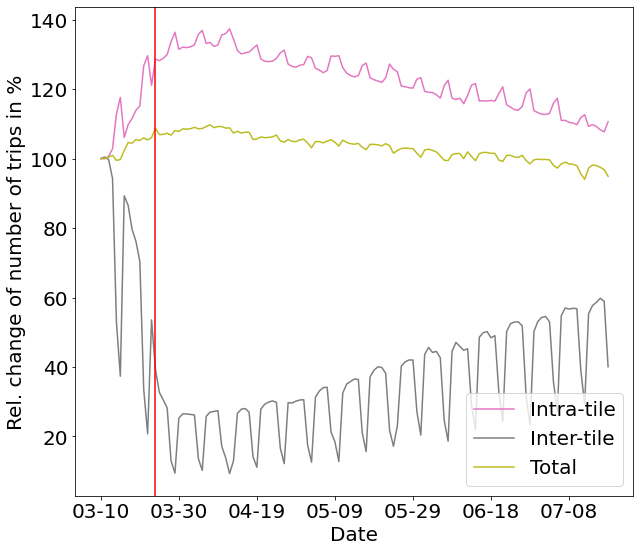

In [20]:
x_days = np.arange(n_days)
fig, ax = plt.subplots(1,figsize =(10,9))
ax.plot(100*results['n_total_intra']/results['n_total_intra'][0],label=r'Intra-tile',color='C6')
ax.plot(100*results['n_total_inter']/results['n_total_inter'][0],label=r'Inter-tile',color='C7')
ax.plot(100*results['n_total']/results['n_total'][0],label=r'Total',color = 'C8')

ax.axvline(x = lockdown_date_number, color = 'red')
ticks = range(0,n_days,20)
ax.set(xticks = ticks, xticklabels = days_dm[ticks], ylabel = 'Rel. change of number of trips in %',
      xlabel = 'Date')
      #,title='Number of trips over time')
ax.legend(loc=4,frameon = True)
plt.show()

fig.savefig(root_figure+'Number_Trips.pdf', dpi=fig.dpi,bbox_inches='tight')

## Load MS and NUTS partitions

In [9]:
# Load data (deserialize)
with open(root_results+'MS_results.pkl', 'rb') as handle:
    all_results = pickle.load(handle)
    
# Get times
times = all_results['times']
min_time = all_results['run_params']['min_time']
max_time = all_results['run_params']['max_time']
n_time = all_results['run_params']['n_time']
log_times = np.linspace(min_time,max_time,n_time)

# collect information for robust partitions
robust_scales = np.asarray([31, 97, 136, 162, 183, 202, 227, 247, 278])

ms_communities = np.zeros((len(robust_scales),n_nodes))

for i, scale in enumerate(robust_scales):
    ms_communities[i] = all_results['community_id'][scale]

ms_communities = np.asarray(ms_communities,dtype='int')

ms_times = log_times[robust_scales]

In [10]:
# Load NUTS3 data
root_NUTS3 = root_processed+'MOVEMENT_QUADKEY_NUTS3_GB.csv'
df_NUTS = pd.read_csv(root_NUTS3)
print('Shape of NUTS3 data:', df_NUTS.shape)

# Delete _ in front of quadkeys
quadkeys = [df_NUTS['quadkey'][i][1:] for i in range(df_NUTS.shape[0])]

# Get NUTS3 region names
NUTS3 = df_NUTS.columns.values.tolist()[1:]

# Get NUTS2 regions
to_NUTS2 = {NUTS3[i] : NUTS3[i][:4] for i in range(len(NUTS3))}
NUTS2_index = {list(to_NUTS2.values())[i] : i for i in range(len(to_NUTS2))}

# Get NUTS1 regions
to_NUTS1 = {NUTS3[i] : NUTS3[i][:3] for i in range(len(NUTS3))}
NUTS1_index = {list(to_NUTS1.values())[i] : i for i in range(len(to_NUTS1))}

# Compute for each quadkey NUTS3 region by max vote 
X = np.asarray(df_NUTS.iloc[:,1:])
max_rule = np.argmax(X,axis = 1)
print('The max is obtained in average with:',
      np.around(np.max(X,axis = 1).mean(),2) )

# Create dictionary from quadkeys to NUTS3 region id's
quadkey_NUTS3 = {quadkeys[i] : max_rule[i] for i in range(df_NUTS.shape[0])}

# Generate NUTS3 Id's for LSCC nodes
NUTS3_id = np.asarray([quadkey_NUTS3[list(lscc.nodes())[i]] for i in range(n_nodes)])
print('NUTS3 communities in LSCC:', len(set(NUTS3_id)))

# Generate NUTS2 Id's
NUTS2_id = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id[i]]]] for i in range(n_nodes)])
print('NUTS2 communities in LSCC:', len(set(NUTS2_id)))

# Generate NUTS1 Id's
NUTS1_id = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id[i]]]] for i in range(n_nodes)])
print('NUTS1 communities in LSCC:', len(set(NUTS1_id)))

Shape of NUTS3 data: (5436, 180)
The max is obtained in average with: 0.93
NUTS3 communities in LSCC: 170
NUTS2 communities in LSCC: 42
NUTS1 communities in LSCC: 12


In [11]:
NUTS_partitions = []

for node_id in [NUTS3_id,NUTS2_id,NUTS1_id]:
    H = compute_indicator_matrix(node_id)
    # delete empty columns
    H = H[:, np.sum(H, axis=0) > 0]
    NUTS_partitions.append(H)

## Compute weekly networks

In [12]:
networks_adjacency = [nx.adjacency_matrix(networks[i]) for i in range(n_networks)]
networks_week = []
networks_week_adjacency = []

for i in weeks:
    days_of_week = np.asarray(np.argwhere(days_week==i).flatten(),dtype = 'int')
    adjacency_week = networks_adjacency[days_of_week[0]:days_of_week[-1]+1]
    A = adjacency_week[0]
    for j in range(1,len(adjacency_week)):
        A+= adjacency_week[j]
    A /= len(adjacency_week)
    
    G = nx.DiGraph(A)
    networks_week.append(G)
    networks_week_adjacency.append(A)

n_weeks = len(networks_week)
networks = networks_week

In [13]:
len(weeks)

18

## Coverage

### a) absolute values

In [22]:
# Compute TFC and IFC for MS partitions over timeseries
MS_TFC = np.zeros((n_weeks,len(ms_times)))


for i in tqdm(range(n_weeks)):
    G = networks[i]
    for j, ms_time in enumerate(ms_times):
        partition = compute_indicator_matrix(ms_communities[j])
        MS_TFC[i,j] = flow_coverage(G,partition,True)      

100%|██████████| 18/18 [00:21<00:00,  1.19s/it]


In [23]:
# Compute TFC and IFC for NUTS partitions over timeseries
NUTS_TFC = np.zeros((n_weeks,3))

for i in tqdm(range(n_weeks)):
    G = networks[i]
    for j in range(3):
        partition = NUTS_partitions[j]
        NUTS_TFC[i,j] = flow_coverage(G,partition,True)

100%|██████████| 18/18 [00:07<00:00,  2.57it/s]


In [25]:
ms_relevant_times = [0,1,3]

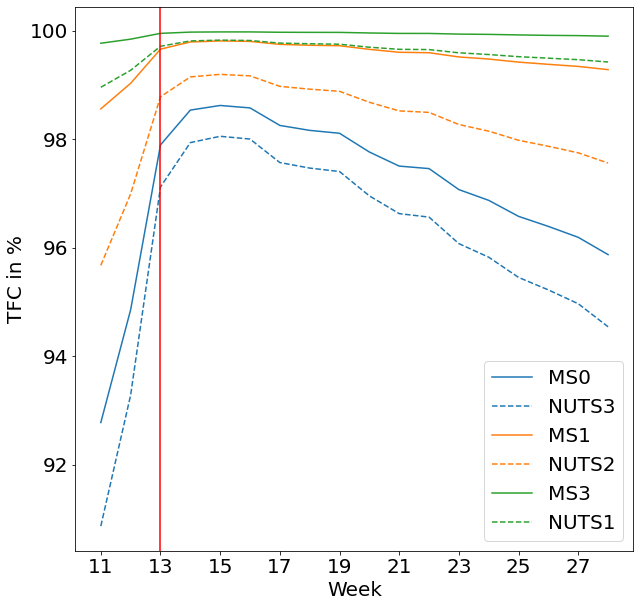

In [26]:
# Plot
fig, ax = plt.subplots(1,figsize =(10,10))
for i in range(3):
    ax.plot(weeks, 100*MS_TFC[:,ms_relevant_times[i]],label = 'MS{}'.format(ms_relevant_times[i]), color = 'C'+str(i))
    ax.plot(weeks, 100*NUTS_TFC[:,i],label = 'NUTS{}'.format(3-i), ls = '--', color = 'C'+str(i))
ax.axvline(x = lockdown_week, color = 'red')
ax.set(xticks = weeks[::2],ylabel = 'TFC in %',xlabel='Week')
ax.legend()
plt.show()
#fig.savefig(root_figure+'days_fcoverage_total.pdf', dpi=fig.dpi,bbox_inches='tight')

### b) ratio of MS and NUTS

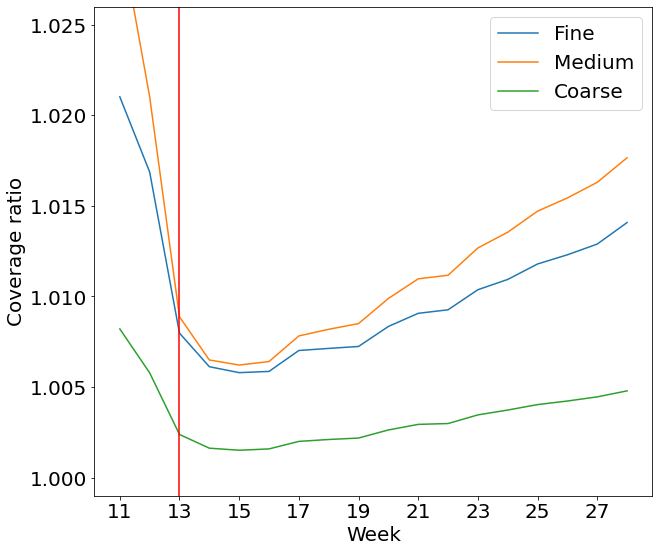

In [27]:
# Plot
fig, ax = plt.subplots(1,figsize =(10,9))
ax.plot(weeks,MS_TFC[:,ms_relevant_times[0]]/NUTS_TFC[:,0],label = 'Fine', color = 'C0')
ax.plot(weeks,MS_TFC[:,ms_relevant_times[1]]/NUTS_TFC[:,1],label = 'Medium', color = 'C1')
ax.plot(weeks,MS_TFC[:,ms_relevant_times[2]]/NUTS_TFC[:,2],label = 'Coarse', color = 'C2')
ax.axvline(x = lockdown_week, color = 'red')
ax.set(xticks = weeks[::2], xlabel = 'Week',ylabel = 'Coverage ratio', ylim = (0.999,1.026))
ax.legend()
fig.savefig(root_figure+'TFC_ratio_WEEKLY.pdf', dpi=fig.dpi,bbox_inches='tight')
plt.show()

### c) response functions

Fine & 0.041822 (0.035504, 0.049732) & 16.4216 (12.4716, 21.4641) & 2.0189 (1.564, 2.6748) &  0 (-) & 100.0 & - & 0.039 & -201.4 & -198.8

Medium & 0.008609 (0.007385, 0.010124) & 18.7916 (14.581, 24.3305) & 1.9218 (1.5227, 2.4635) &  0 (-) & 100.0 & - & 0.017 & -262.2 & -259.6

Coarse & 0.001372 (0.001171, 0.001623) & 20.8744 (15.7184, 28.03) & 1.9794 (1.5536, 2.5677) &  0 (-) & 100.0 & - & 0.007 & -325.8 & -289.0



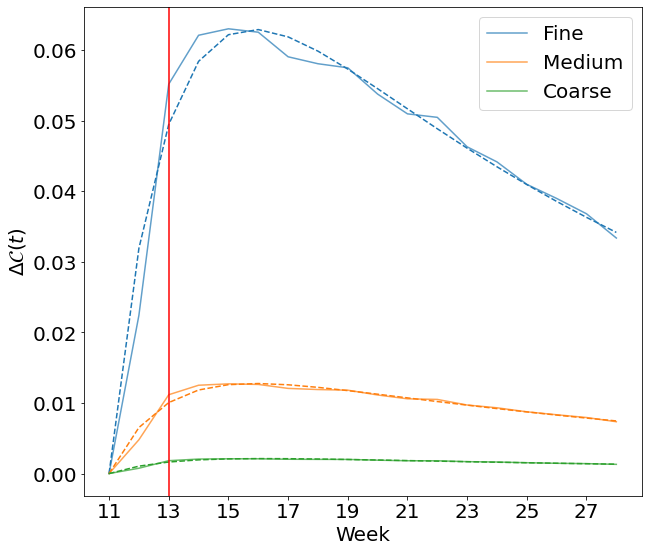

In [28]:
x_days = np.arange(n_weeks)

# Plot
fig, ax = plt.subplots(1,figsize =(10,9))
ax.set(xticks = weeks[::2], xlabel = 'Week',ylabel = r'$\Delta\mathcal{C}(t)$')
labels = ['Fine','Medium','Coarse']

for i in range(3):

    # Fit model to MS       
    ls = select_model(MS_TFC[:,ms_relevant_times[i]],MS_TFC[0,ms_relevant_times[i]], name=labels[i],use_window=False,use_m=False,decimals=4)

    # Plot MS
    ax.plot(weeks,MS_TFC[:,ms_relevant_times[i]]/MS_TFC[0,ms_relevant_times[i]]-1,color = 'C'+str(i),
            label = labels[i],alpha=0.7)
    ax.plot(weeks, ls.eval(ls.params, x=x_days)-1,color = 'C'+str(i), linestyle = '--')

ax.axvline(x = lockdown_week, color = 'red')
ax.legend(loc=1)
fig.savefig(root_figure+'TFC_response_WEEKLY_FD.pdf', dpi=fig.dpi,bbox_inches='tight')
plt.show()

$s_1=-1.48$ & 0.041822 (0.0355036, 0.0497322) & 16.4216 (12.47155, 21.4641) & 2.0189 (1.56401, 2.67475) &  0 (-) & 100.0 & - & 0.039 & -201.4 & -198.8

$s_2=-0.38$ & 0.0086092 (0.0073855, 0.0101244) & 18.79157 (14.58102, 24.33048) & 1.92184 (1.52266, 2.46355) &  0 (-) & 100.0 & - & 0.017 & -262.2 & -259.6

$s_3=0.27$ & 0.0033662 (0.0028928, 0.0039519) & 21.80416 (16.80962, 28.70312) & 1.87443 (1.49452, 2.37867) &  0 (-) & 100.0 & - & 0.011 & -297.1 & -294.3

$s_4=0.71$ & 0.0013724 (0.0011714, 0.001623) & 20.87437 (15.71836, 28.03003) & 1.97945 (1.5536, 2.56769) &  0 (-) & 100.0 & - & 0.007 & -325.8 & -289.0

$s_5=1.06$ & 0.0008969 (0.0007659, 0.0010604) & 21.40514 (16.20768, 28.66014) & 1.93168 (1.52095, 2.49142) &  0 (-) & 100.0 & - & 0.006 & -342.1 & -305.3

$s_6=1.38$ & 0.0006265 (0.0005299, 0.0007482) & 18.77844 (13.84181, 25.48422) & 2.0734 (1.59517, 2.77091) &  0 (-) & 100.0 & - & 0.005 & -350.5 & -313.5

$s_7=1.8$ & 0.000478 (0.0004078, 0.0005657) & 20.87913 (15.64313, 28.16865)

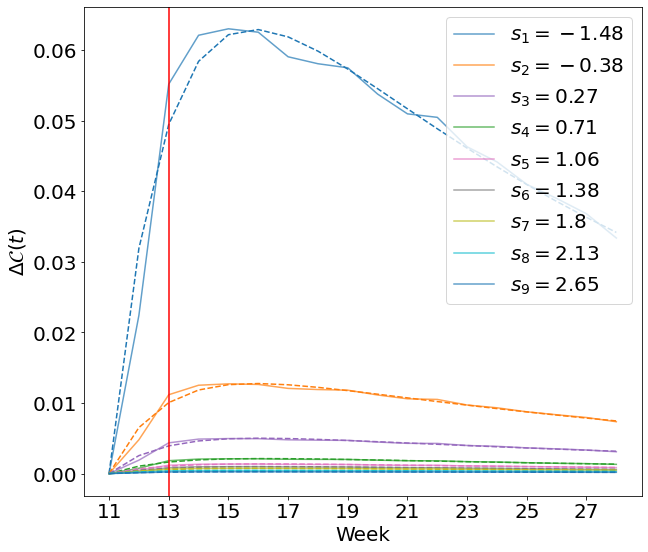

In [29]:
x_days = np.arange(n_weeks)

# Plot
fig, ax = plt.subplots(1,figsize =(10,9))
ax.set(xticks = weeks[::2], xlabel = 'Week',ylabel = r'$\Delta\mathcal{C}(t)$')

for i in range(len(robust_scales)):

    # Fit model to MS       
    ls = select_model(MS_TFC[:,i],MS_TFC[0,i], name=r'$s_{}={}$'.format(i+1,np.around(ms_times[i],2)),use_window=False,use_m=False,decimals=5)

    if i < 2:
        color = 'C'+str(i)
    if i == 2:
        color = 'C4'
    if i == 3:
        color = 'C2'
    if i > 3:
        color = 'C'+str(i+2)

    # Plot MS
    ax.plot(weeks,MS_TFC[:,i]/MS_TFC[0,i]-1,color = color,
            label = r'$s_{}={}$'.format(i+1,np.around(ms_times[i],2)),alpha=0.7)
    ax.plot(weeks, ls.eval(ls.params, x=x_days)-1,color = color, linestyle = '--')

ax.axvline(x = lockdown_week, color = 'red')
ax.legend(loc=1)
fig.savefig(root_figure+'TFC_response_WEEKLY_FD_all_scales.pdf', dpi=fig.dpi,bbox_inches='tight')
plt.show()

## Response parameters for Coverage on community level

### a) TFC at community level for MS0

In [ ]:
n_communities = len(set(ms_communities[0]))
partition = compute_indicator_matrix(ms_communities[0])

TFC_k_MS0 = np.zeros((n_weeks+1,n_communities))

# baseline
TFC_k_MS0[0,:] = flow_coverage_community(lscc,partition,True)

# timeseries
for i  in tqdm(range(n_weeks)):
    G = networks[i]
    TFC_k_MS0[i+1,:] = flow_coverage_community(G,partition,True)

# store results
with open(root_results + "TFC_k_MS0_WEEKLY.pkl", "wb") as handle:
    pickle.dump(
        TFC_k_MS0, handle, protocol=pickle.HIGHEST_PROTOCOL,
    )

### b) fitting of response curves

In [31]:
partition = compute_indicator_matrix(ms_communities[0])

In [32]:
with open(root_results + "TFC_k_MS0_WEEKLY.pkl", 'rb') as handle:
    TFC_k_MS0 = pickle.load(handle)

n_communities = len(set(ms_communities[0]))

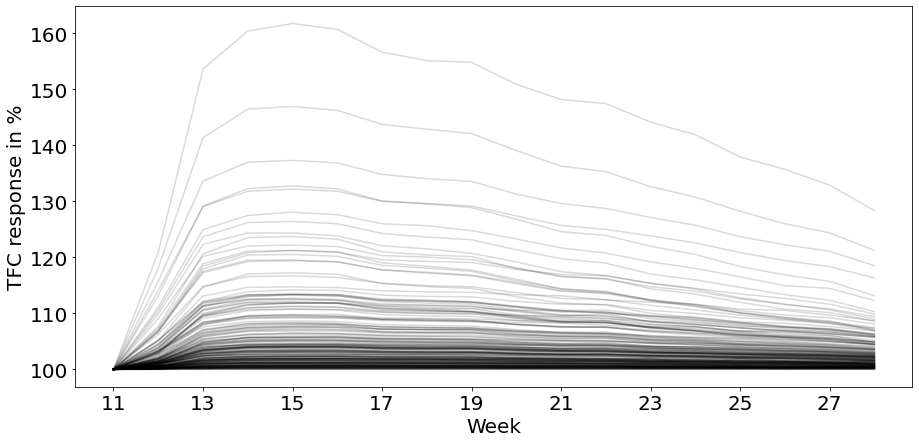

In [33]:
fig, ax = plt.subplots(1,figsize =(15,7))

ticks = range(0,n_weeks,2)

for j in range(n_communities):
    feature = TFC_k_MS0[1:,j]
    base_value = TFC_k_MS0[0,j]

    if np.isnan(feature).any():
        pass
    else:
        signal = np.asarray(feature / feature[0])
        ax.plot(weeks,100*signal,color = 'black', alpha=0.15)
    
ax.set(xticks = weeks[::2], xlabel = 'Week',ylabel = 'TFC response in %')
    
    
plt.show()
    

In [44]:
base = np.zeros(n_communities)
alphas_TFC = np.zeros(n_communities)
betas_TFC = np.zeros(n_communities)
lambdas_TFC= np.zeros(n_communities)
ms = np.zeros(n_communities)
lims = np.zeros(n_communities)
CVRMSEs = np.zeros(n_communities)

for j in tqdm(range(n_communities)):

    # Get baseline IFC
    base_value = TFC_k_MS0[0,j]

    # Get timeseries IFC
    feature = TFC_k_MS0[1:,j]
    
    if np.isnan(feature).any():

        # Add values
        base[j] = base_value
        alphas_TFC[j] = np.NaN
        betas_TFC[j] = np.NaN
        lambdas_TFC[j] = np.NaN
        ms[j] = np.NaN
        lims[j] = np.NaN
        CVRMSEs[j] = np.NaN

    else:

        try:

            # Compute response parameters
            alpha, beta, lamb, m, lim, CVRMSE = return_response_parameters(feature,feature[0],use_window=False,use_m=False)
            
            # Add values
            base[j] = base_value
            alphas_TFC[j] = alpha
            betas_TFC[j] = beta
            lambdas_TFC[j] = lamb
            ms[j] = m
            lims[j] = lim
            CVRMSEs[j] = CVRMSE

        except:

            base[j] = base_value
            alphas_TFC[j] = np.NaN
            betas_TFC[j] = np.NaN
            lambdas_TFC[j] = np.NaN
            ms[j] = np.NaN
            lims[j] = np.NaN
            CVRMSEs[j] = np.NaN



100%|██████████| 201/201 [00:02<00:00, 92.62it/s] 


### c) response maps

In [45]:
import geopandas as gpd
import mercantile
from shapely.geometry import shape

In [37]:
#######################
# Load map shape file #
#######################

map_df = gpd.read_file(root_map)
map_df['DUMMY'] = 1
# Dissovle to one shape
map_df2 = map_df.dissolve(by='DUMMY')
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['patch.facecolor'] = 'b'
map_df = map_df.to_crs("EPSG:3395")
map_df2 = map_df2.to_crs("EPSG:3395")

# Get quadkeys from lscc
quadkeys = list(lscc.nodes())
polys = []

# Iterate over all quadkeys to create corresponding polygons
for quadkey in quadkeys:
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))
geom = [shape(i) for i in polys]
gdf = gpd.GeoDataFrame({'geometry':geom, 'quadkey':quadkeys}, crs = "EPSG:4326")
gdf = gdf.to_crs("EPSG:3395")

In [46]:
gdf['alpha_TFC']= [alphas_TFC[tile_comm] for tile_comm in ms_communities[0]]
gdf['beta_TFC']= [betas_TFC[tile_comm] for tile_comm in ms_communities[0]]
gdf['beta_inv_TFC'] = 1/gdf['beta_TFC']
gdf['is_nan_TFC'] = [int(np.isnan(alphas_TFC)[tile_comm])for tile_comm in ms_communities[0]]
gdf['lambda_TFC'] = [lambdas_TFC[tile_comm] for tile_comm in ms_communities[0]]
gdf['lambda_inv_TFC'] = 1/gdf['lambda_TFC']

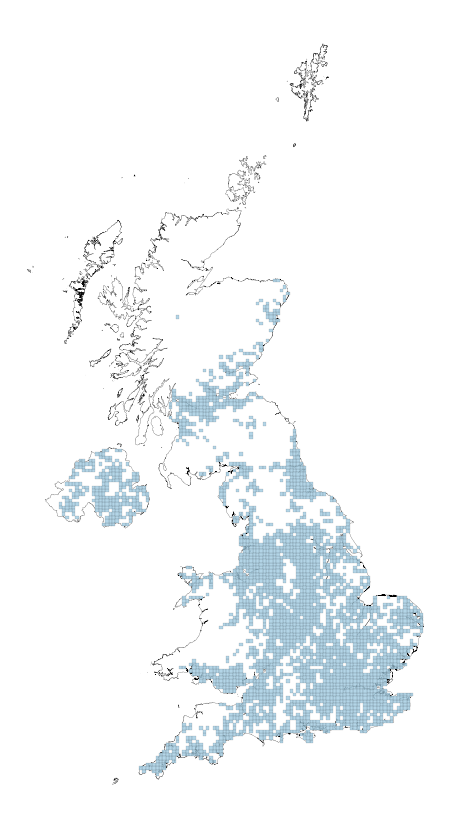

In [48]:
fig, ax = plt.subplots(1,figsize =(20,15))

tile_width = 0.1
map_width = 0.2

map_df2.plot(linewidth=map_width, ax=ax, facecolor = 'none')
im = gdf.plot('is_nan_TFC',alpha = 0.85, linewidth = tile_width,ax=ax, cmap='Paired',edgecolor='black')
ax.set_axis_off()

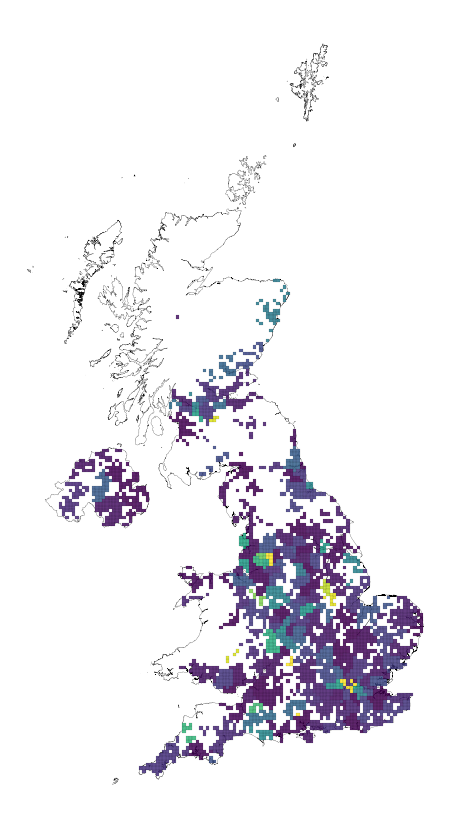

In [49]:
fig, ax = plt.subplots(1,figsize =(20,15))

tile_width = 0.1
map_width = 0.2

vmin_alpha_TFC = np.percentile(alphas_TFC[~np.isnan(alphas_TFC)],5)
vmax_alpha_TFC = np.percentile(alphas_TFC[~np.isnan(alphas_TFC)],95)

map_df2.plot(linewidth=map_width, ax=ax, facecolor = 'none')
im = gdf.plot('alpha_TFC',alpha = 0.85, linewidth = tile_width,ax=ax, #cmap='coolwarm',
vmin=vmin_alpha_TFC,vmax=vmax_alpha_TFC,edgecolor='black')
ax.set_axis_off()

fig.savefig(root_figure+'MS0_alphas_TFC_WEEKLY_FD.pdf', dpi=fig.dpi,bbox_inches='tight')

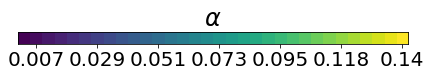

In [50]:
# Plot colourbar
n_steps = 32
fig, ax = plt.subplots(1, figsize=(7, 5))
ax.imshow(np.linspace(vmin_alpha_TFC,vmax_alpha_TFC,n_steps).reshape(1,n_steps))
ax.set(yticks=[],xticks = np.arange(0,n_steps,5)+1,
        xticklabels=np.around(np.asarray(np.linspace(vmin_alpha_TFC,vmax_alpha_TFC,n_steps)),3)[np.arange(0,n_steps,5)+1],
        title=r'$\alpha$')
plt.show()

fig.savefig(root_figure+'MS0_alphas_TFC_WEEKLY_FD_legend.pdf', dpi=fig.dpi,bbox_inches='tight')

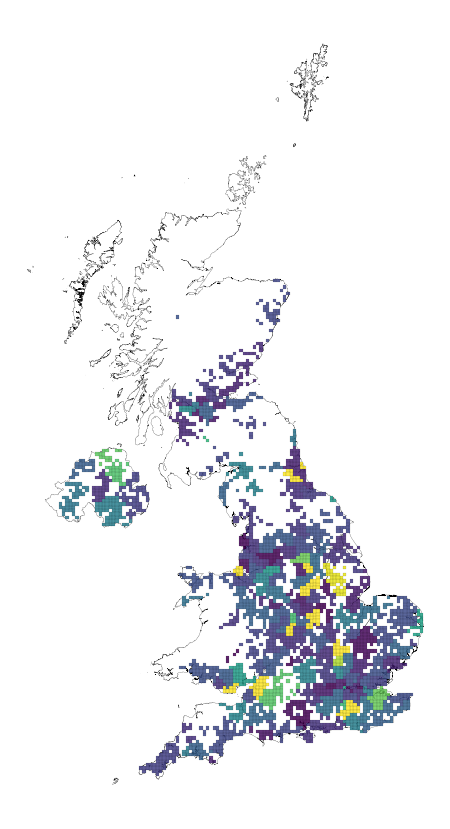

In [51]:
fig, ax = plt.subplots(1,figsize =(20,15))

tile_width = 0.1
map_width = 0.2

vmin_beta_inv_TFC = np.percentile(1/betas_TFC[~np.isnan(1/betas_TFC)],5)
vmax_beta_inv_TFC = np.percentile(1/betas_TFC[~np.isnan(1/betas_TFC)],95)

map_df2.plot(linewidth=map_width, ax=ax, facecolor = 'none')
im = gdf.plot('beta_inv_TFC',alpha = 0.85, linewidth = tile_width,ax=ax, #cmap='coolwarm',
vmin=vmin_beta_inv_TFC,vmax=vmax_beta_inv_TFC,edgecolor='black')
ax.set_axis_off()

fig.savefig(root_figure+'MS0_betas_inv_TFC_FD_WEEKLY.pdf', dpi=fig.dpi,bbox_inches='tight')

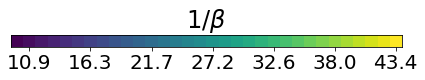

In [52]:
# Plot colourbar
n_steps = 32
fig, ax = plt.subplots(1, figsize=(7, 5))
ax.imshow(np.linspace(vmin_beta_inv_TFC,vmax_beta_inv_TFC,n_steps).reshape(1,n_steps))
ax.set(yticks=[],xticks = np.arange(0,n_steps,5)+1,
        xticklabels=np.around(np.asarray(np.linspace(vmin_beta_inv_TFC,vmax_beta_inv_TFC,n_steps)),1)[np.arange(0,n_steps,5)+1],
        title=r'$1/\beta$')
plt.show()

fig.savefig(root_figure+'MS0_betas_inv_TFC_WEEKLY_FD_legend.pdf', dpi=fig.dpi,bbox_inches='tight')

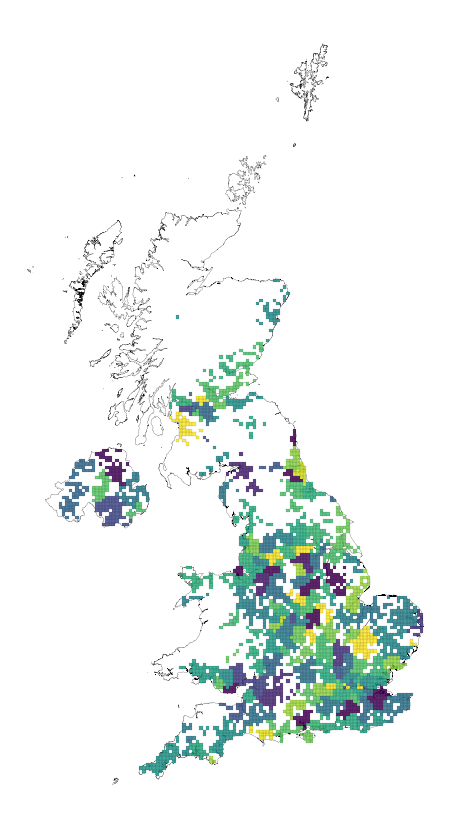

In [53]:
fig, ax = plt.subplots(1,figsize =(20,15))

tile_width = 0.1
map_width = 0.2

vmin_lambda_inv_TFC = np.percentile(1/lambdas_TFC[~np.isnan(1/lambdas_TFC)],5)
vmax_lambda_inv_TFC = np.percentile(1/lambdas_TFC[~np.isnan(1/lambdas_TFC)],95)

map_df2.plot(linewidth=map_width, ax=ax, facecolor = 'none')
im = gdf.plot('lambda_inv_TFC',alpha = 0.85, linewidth = tile_width,ax=ax, #cmap='coolwarm',
vmin=vmin_lambda_inv_TFC,vmax=vmax_lambda_inv_TFC, edgecolor='black')
ax.set_axis_off()

fig.savefig(root_figure+'MS0_lambdas_inv_TFC_WEEKLY_FD.pdf', dpi=fig.dpi,bbox_inches='tight')

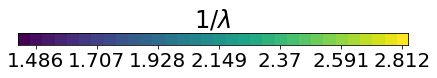

In [54]:
# Plot colourbar
n_steps = 32
fig, ax = plt.subplots(1, figsize=(7, 5))
ax.imshow(np.linspace(vmin_lambda_inv_TFC,vmax_lambda_inv_TFC,n_steps).reshape(1,n_steps))
ax.set(yticks=[],xticks = np.arange(0,n_steps,5)+1,
        xticklabels=np.around(np.asarray(np.linspace(vmin_lambda_inv_TFC,vmax_lambda_inv_TFC,n_steps)),3)[np.arange(0,n_steps,5)+1],
        title=r'$1/\lambda$')
plt.show()

fig.savefig(root_figure+'MS0_lambdas_inv_TFC_WEEKLY_FD_legend.pdf', dpi=fig.dpi,bbox_inches='tight')